# CAHW 2 CA and M2M Interface

The purpose of this notebook is to turn to the Cabled Array and trace the process of identifying individual instruments and
plotting data from those instruments. Features include...


- Pulling an explanatory image to GitHub for display in this notebook

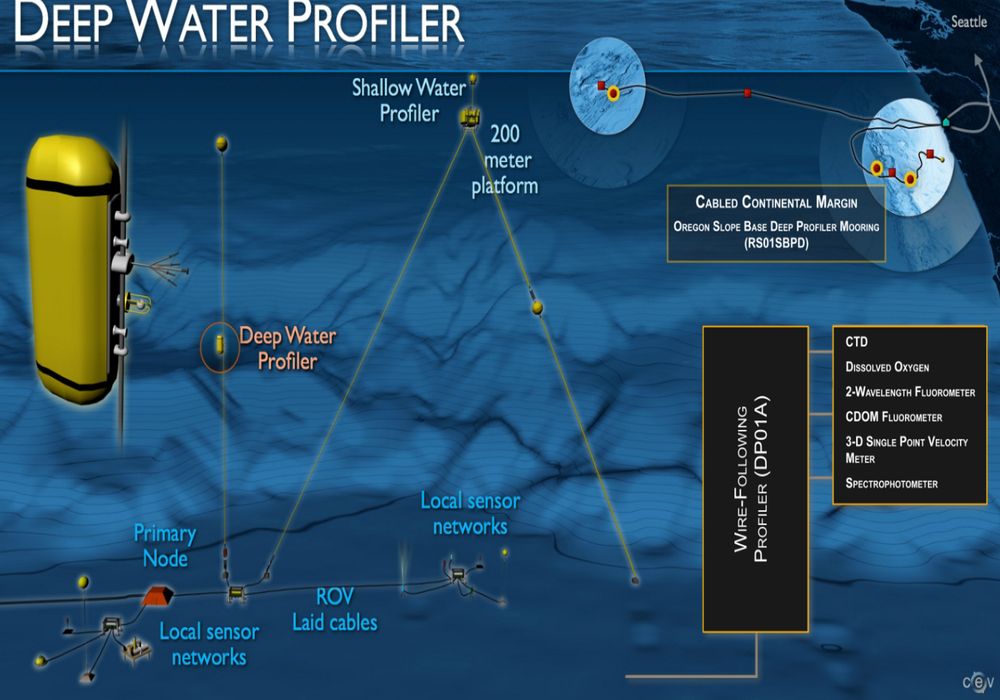

In [7]:
import kilroy
kilroy.ShowImageFromGitHub('oceanhackweek', 'cahw2018_tutorials','source_material','',\
                           'Diagram_Three_Installation_Types_in_CA.png',1000,700)

### CAHW = Cabled Array Hack Workshop held 21-23 February 2018 at UW


Objective: Explore the OOI Machine to Machine (M2M) Realtime Interface


- This notebook is a modification of an original by Friedrich Knuth
- (Rob Fatland January 31, 2018)


## Getting Started

* Create a user account on ooinet.oceanobservatories.org: Requires email and password.
* Log in
* Navigate to the drop down menu screen in the top-right corner menu: 'User Profile'
* Notice at the bottom of your user profile your API Username and your API Token. 
  * The API Username is similar to “OOIAPI-QTULEV9STCAS55”. 
  * The API Token is similar to “YXP2Q2W4SOP”.
  * Your API Token may identify itself as temporary. If it *is* hit the **Refresh** button and then save your profile.
* Save these two strings in a file called <home>/creds/ooiauth.txt
  * You can run `chmod 400` on this file to make it readable only by you
  * Place them on a single line separated by a comma like this


```
OOIAPI-QTULEV9STCAS55,YXP2Q2W4SOP
```


We place them in a file that can be separated from your IPython notebook so that you are not hardcoded credentials
in your code. If for example you were to move this notebook file to a git repository on GitHub you can instruct 
GitHub to ignore the ooiauth.txt file. In this way you avoid providing access to your account to anybody who happens
to look at your (open-to-the-world) repository. 


The next cell reads your credentials from your **<home>/creds/ooiauth.txt** file. 

In [1]:
# Read connection credentials from a file (should be saved in this same directory)
authfile=open('../creds/ooiauth.txt','r')     # format of this file is username,token
line=authfile.readline().rstrip()    # please note rstrip() removes any trailing \n whitespace
authfile.close()
username, token = line.split(',')

### Where are the installations, how are they referenced

[This page](http://ooi.visualocean.net/regions/view/CE) lists the nine Oregon **Coastal Endurance** installations, of which four are supported on the cabled array. It also lists 'mobile assets' and six moorings off the coast of Washington. Cabled: 


* Oregon Shelf Cabled Benthic Experiment Package (sea floor, depth 79 meters apparently)
* Oregon Offshore Cabled Benthic Experiment Package
* Oregon Offshore Cabled Deep Profiler Mooring
* Oregon OFfshore Cabled Shallow Profiler Mooring


Meanwhile [this page](https://ooinet.oceanobservatories.org/) with the cabled array selected provides a low-resolution 
diagram and a separate listing of assets. We want to enumerate the cabled array assets so let's begin by trying to 
compare these two listings. 

From OOINET we have (distinct from the above)

* Southern Hydrate Summit 1 
* Southern Hydrate Summit 2: These two are very nearly co-located.
* Oregon Slope Base Seafloor
* Oregon Slope Base Shallow Profiler Mooring

...and then eight more installations way out at Axial.


### Relationship between instruments and installations: Two profiler types plus benthics


[The diagram at the top of this page](http://oceanobservatories.org/wp-content/uploads/2015/09/RS01SBPD_OR_Slope_Base_Deep_Profiler.jpg) 
explains the three basic installations schemes: Deep profilers, shallow profilers, and benthic installations. 


- Benthics are on the bottom with nothing moving through the water column. 
- Deep profilers go up and down a wire which is distended vertically off the bottom via a float; well under the surface. 
- Shallow profilers are moored by means of two long cables to a point some way under the surface
  - Shallow profilers use a winch to extend a positively buoyant instrument package up to within 20 meters of so of the surface. 


Let's follow the sequence of websites to where we could fill out the input variables to get to the data.

- [Directory of resources; including CA (code letters RS)](http://ooi.visualocean.net/)
- [Platform list for the cabled array (RS)](http://ooi.visualocean.net/regions/view/RS)
- [Instrument list for a platform (Oregon slope base shallow profiler mooring)](http://ooi.visualocean.net/sites/view/RS01SBPS)
- [Details for a chosen instrument on that platform (nitrate)](http://ooi.visualocean.net/instruments/view/RS01SBPS-SF01A-4A-NUTNRA101)
- [Data products page for the nitrate instrument](http://ooi.visualocean.net/streams/view/nutnr_a_sample)

In this example we will request pressure data from the Cabled Axial Base (RS03AXPS) - Shallow Profiler (SF03A) - CTD (2A-CTDPFA302) sensor.

Reference Designator: RS03AXPS-SF03A-2A-CTDPFA302  
Delivery Method: streamed  
Stream: ctdpf_sbe43_sample  
Parameter: seawater_pressure  

A good resource for finding the information you will need to input below is the Data Team Portal at http://ooi.visualocean.net/. This resource allows you to identify the Reference Designator, Delivery Method, Stream, and Parameter, alongside english descriptions of the instruments and data products.

In [14]:
# specify your inputs
# Reference designator RS01SBPS-SF01A-4A-NUTNRA101
sub_site = 'RS01SBPS'
platform = 'SF01A'
instrument = '4A-NUTNRA101'
delivery_method = 'streamed'                # this taken from the Method column in the table below
stream = 'nutnr_a_sample'                   # this taken from the Data Stream column in the same table
parameter = 'salinity_corrected_nitrate'    # this from clicking on the Data Stream link to the products page

# Friedrich's example
sub_site = 'RS03AXPS'
platform = 'SF03A'
instrument = '2A-CTDPFA302'
delivery_method = 'streamed'
stream = 'ctdpf_sbe43_sample'
parameter = 'seawater_pressure'

In [15]:
import datetime
import time
import requests
import pprint
from concurrent.futures import ThreadPoolExecutor

In [16]:
# setup the base url for the request that will be built using the inputs above.
BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# we use ThreadPoolExecutor because it has a method .done, which can be polled for 
# completed of the task executed on that thread.
pool = ThreadPoolExecutor(1)

# time stamps are returned in time since 1900, so we subtract 70 years from 
# the time output using the ntp_delta variable
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

In [17]:
# convert timestamps
def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

# send request on a thread
def get_future_data(url, params, username, token):
    auth = (username, token)
    return pool.submit(requests.get, url, params=params, auth=auth)

# parse response for timestamp and inform user if no new data returned
def extract_keys(data, keys, min_time):
    rdict = {key: [] for key in keys}
    for record in data:
        if record['time'] <= min_time:
            time_r = record['time']
            time_r = ntp_seconds_to_datetime(time_r)
            time_r = time_r.strftime("%Y-%m-%d %H:%M:%S.000Z")
            print('No new data found since ' + str(time_r) + '. Sending new request.')
            continue
        for key in keys:
            rdict[key].append(record[key])
    print('Found %d new data points after filtering' % len(rdict['time']))
    return rdict


The following script is the main script. It will execute 10 requests, but if put into a while loop it can execute data requests indefinitely. See comments for explanations in line. The data response in json format contains all parameters under the input data stream, however, only prints out the values for the input parameter and corresponding timestamp. Note that the maximum points returned for a given time interval is 1000 points. Right now, the script sends a new request every 0.1 seconds, so you should never receive exceed 1000 points.

In [18]:
def requestNow(username, token, sub_site, platform, instrument, delivery_method, stream, parameter):
    
    # create the base url
    request_url = '/'.join((BASE_URL, sub_site, platform, instrument, delivery_method, stream))
    
    # specify parameters which will be used in the get_future_data function. 
    # with each new request being sent, only the beginDT will change. 
    # it will be set to the time stamp of the last data point received. 
    # notice that there is no endDT specified, as a request with a beginDT 
    # and no endDT will return everything  from beginDT until present, 
    # up to 1000 data points.
    params = {
        'beginDT': None,
        'limit': 1000,
        'user': 'realtime',
    }
    
    # start with the last 10 seconds of data from present time
    begin_time = datetime.datetime.utcnow() - datetime.timedelta(seconds=10)
    
    # last_time will be assigned as the time stamp of the last data point 
    # received once the first request is sent
    last_time = 0
    
    for i in range(10): # replace with `while True:` to enter an endless data request loop
        
        # update beginDT for this request
        begin_time_str = begin_time.strftime('%Y-%m-%dT%H:%M:%S.000Z')
        params['beginDT'] = begin_time_str

        # send request in thread
        data_future = get_future_data(request_url, params, username, token)
        
        # poll until complete
        while not data_future.done:
            # while request not complete, yield control to event loop
            time.sleep(0.1)

        # request complete, if not 200, log error and try again
        response = data_future.result()
        if response.status_code != 200:
            print('Error fetching data', response.text)
            time.sleep(0.1)
            continue
        
        # store json response
        data = response.json()
        
        # use extract_keys function to inform users about whether 
        # or not data is being returned. parse data in json response 
        # for input parameter and corresponding timestamp
        data = extract_keys(data, ['time', parameter], min_time=last_time)

        # if no data is returned, try again
        if not data['time']:
            time.sleep(0.1)
            continue

        # set beginDT to time stamp of last data point returned
        last_time = data['time'][-1]
        begin_time = ntp_seconds_to_datetime(last_time)

        # print data points returned
        print("\n")
        pprint.pprint(data)
        print("\n")
        

In [19]:
requestNow(username, token, sub_site, platform, instrument, delivery_method, stream, parameter)

Found 9 new data points after filtering


{'seawater_pressure': [102.13369591079316,
                       102.230589766577,
                       102.34351703108769,
                       102.45974651191648,
                       102.586523668252,
                       102.70594950576816,
                       102.81466891294428,
                       102.91587793877378,
                       102.99998833419457],
 'time': [3727822072.635823,
          3727822073.636038,
          3727822074.635627,
          3727822075.6360507,
          3727822076.6355367,
          3727822077.636168,
          3727822078.635967,
          3727822079.635765,
          3727822080.635667]}


No new data found since 2018-02-17 02:08:00.000Z. Sending new request.
Found 0 new data points after filtering
No new data found since 2018-02-17 02:08:00.000Z. Sending new request.
Found 0 new data points after filtering
No new data found since 2018-02-17 02:08:00.000Z. Sending new request.
Found 5 new dat